In [1]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
import yt
import matplotlib.cm as cm
from plot_variables import *
from yt.utilities.math_utils import ortho_find


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
from helper_functions import *

In [3]:
ds = yt.load("/disk14/sgordon/pleiades-11-12-23/seed1-bh-only/270msun/thermal-fb/1B.th.bf128/DD0600/DD0600")

yt : [INFO     ] 2024-04-03 09:50:30,729 Parameters: current_time              = 13.984875219842
yt : [INFO     ] 2024-04-03 09:50:30,730 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-04-03 09:50:30,731 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-03 09:50:30,758 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-04-03 09:50:30,759 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-04-03 09:50:30,760 Parameters: current_redshift          = 26.240077770767
yt : [INFO     ] 2024-04-03 09:50:30,762 Parameters: omega_lambda              = 0.734
yt : [INFO     ] 2024-04-03 09:50:30,763 Parameters: omega_matter              = 0.266
yt : [INFO     ] 2024-04-03 09:50:30,765 Parameters: omega_radiation           = 0
yt : [INFO     ] 2024-04-03 09:50:30,766 Parameters: hubble_constant           = 0.71


In [5]:
data_files = ['data_files/data-1B.RSb01-2.csv', 
              #'data_files/data-2B.RSb01.csv',
              'data_files/data-1B.resim.th.b01.csv']

def extract_filename_parts(file_paths):
    extracted_parts = []
    for path in file_paths:
        # Extract the base name of the file (e.g., 'data-1B.resim.th.b01-3-eta-0.1.csv')
        base_name = os.path.basename(path)
        # Remove the prefix 'data-' and the file extension '.csv'
        clean_name = base_name.replace('data-', '').rsplit('.', 1)[0]
        extracted_parts.append(clean_name)
    return extracted_parts

label = extract_simulation_name_from_csv(data_files[1])
label

'1B.resim.th.b01'

In [6]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    #axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    #axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs


In [7]:
def dynamical_timescale_ff(rho):
    # rho in g/cm^3
    return np.sqrt(3*np.pi/(32*6.67e-8*rho))

def dynamical_timescale_vel(v_orb, r):
    # v in cm/s, r in cm
    return 2*np.pi*r/v_orb

def temperature_from_cs(df):
    kb = 1.38e-16 # Boltzmann in erg/K
    mu = 1.3 # mean molecular weight
    gamma = 1.6667
    cs2 = [i*i for i in df['average cinfinity'].dropna().values]
    temp = cs2*mu/(kb*gamma)
    return temp

def sound_crossing_timescale(df, window_size=10, type='jeans'):
    pc_to_km = 3.086e13
    s_to_myr = 1/3.154e13
    scale_df = df['Jeans length'].replace(0, pd.NA).dropna() if type == 'jeans' else df['Bondi radius'].replace(0, pd.NA).dropna()
    cs_df = df['average cinfinity'].replace(0, pd.NA).dropna()
    print(scale_df.shape, cs_df.shape)
    if scale_df.shape != cs_df.shape:
        print('Lengths do not match')
        return
    return (scale_df*pc_to_km/cs_df)*s_to_myr

In [8]:
# Set up plot environment
fontsize = 12
linewidth = 2
alpha = 1
window_size = 100
setup_plot_env(fontsize, linewidth)
num_subplots = 4
#title = '270msun resimulated from 31.7 Myr with thermal feedback'
title = '270msun with thermal feedback (no stellar phase)'

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb04.csv', 
              #'data_files/data-2B.RSb01.csv',
              #'data_files/data-1B.resim.th.b01.csv'
    'data_files/data-1B.RSb01-2.csv',
    'data_files/data-1B.resim.th.b01-3-eta-0.1.csv',
    'data_files/data-1B.resim.th.b01-3-eta-0.01.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.001.csv',
    'data_files/data-1B.resim.th.b01-3-eps-0.0001.csv'
    # 'data_files/data-1B.RSb01-2.csv',
    # 'data_files/data-1B.th.bf128.csv',
    # 'data_files/data-1B.th.bf128-eps-0.01.csv',
    # 'data_files/data-1B.th.bf128-eps-0.0001.csv',
    ]

# Line colours
c = extract_colors('arbre', int(len(data_files)), start=0.1, end=0.86) # start=0.33, end=0.92 for 10.8msun-no-sn
#c_s2 = extract_colors('magma', int(len(data_files)/2), portion="middle", start=0.4, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
#c = np.concatenate((c_s1, c_s2))

# Data labels
labels = extract_filename_parts(data_files)
#labels = ['no-fb', r"$\rm \eta=0.1$, $\epsilon=0.05$", r"$\times 0.1$", r"$\times 0.05$", r"$\times 0.005$"]
#labels = ["no-fb", r"$\rm \eta=0.1, \epsilon=0.05$", r"$\epsilon=0.01$", r"$\epsilon=0.0001$"]

# Define rho for the dynamical timescale
rho_index = 1
df = pd.read_csv(data_files[rho_index]).dropna()
rho = df['average density'].values.mean()
t_cs = sound_crossing_timescale(df, window_size, type='bondi')
print(r"$\rho$ = {:.0e}".format(rho))

# find the dynamical timescale 
mh = 1.6735e-24 # hydrogen mass in g
t_ff = dynamical_timescale_ff(rho*mh)/3.15576e13

(1266,) (1266,)
$\rho$ = 1e+06


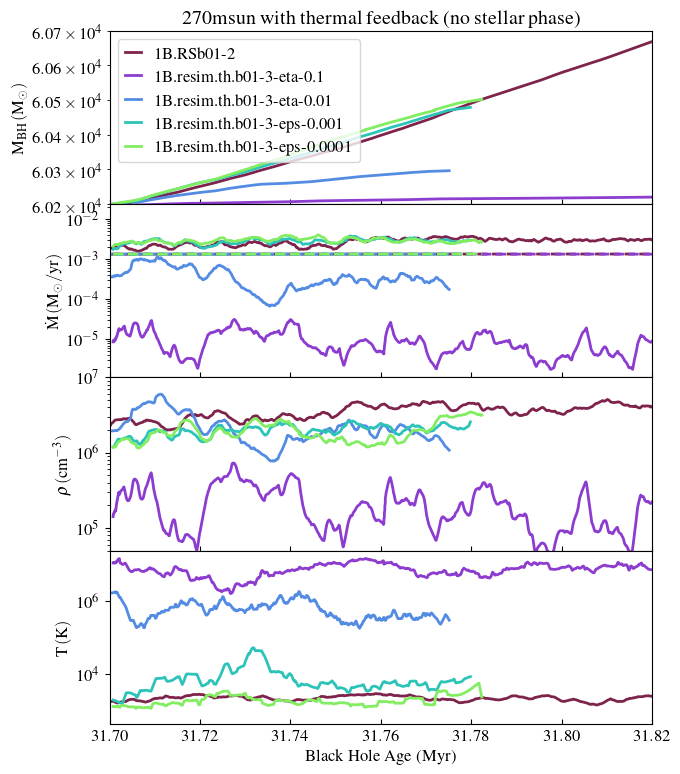

In [9]:

fig, axs = plt.subplots(num_subplots, 1)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    #age = df['age'].values/1e6
    age = (df['age'].values/1e6)/t_cs.mean() if age_units == "t_cs" else (df['age'].values/1e6)/t_ff if age_units == "t_ff" else df['age'].values/1e6
    bh_mass = adaptive_moving_average(df['BH mass'].values, window_size)
    accrate = adaptive_moving_average(df['accrate'].values, window_size)
    density = adaptive_moving_average(df['average density'].values, window_size)
    temperature = adaptive_moving_average(df['temperature'].values, window_size)

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)

    # 3) Density
    axs[2].plot(age, density, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 3) temperature
    axs[3].plot(age, temperature, color=c[j], linestyle='solid', label=labels[j], alpha=alpha) #if j != 0 else None


# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    ax.set_xlim([31.70, 31.82]) # set xlim
    ax.set_xticklabels([]) if i < 3 else None

# Set y-axis limits
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[2].set_yscale('log')
axs[3].set_yscale('log')
axs[0].set_ylim([6.02e4, 6.07e4])
axs[2].set_ylim([5e4, 1e7])

# Set labels
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm \rho \, (cm^{-3})$", fontdict=None)
axs[3].set_ylabel(r"$\rm T \, (K)$", fontdict=None)
if age_units == "t_cs":
    axs[-1].set_xlabel(r'$t_{{c_s}} (t_{{c_s}} = {:.0e}$ Myr, line \ {})'.format(t_cs.mean(), rho_index+1), fontdict=None)
elif age_units == "t_ff":
    axs[-1].set_xlabel(r'$t_{{ff}} (\rho = {:.0e}, line \ {})$'.format(rho, rho_index+1), fontdict=None)
else:
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# legend and title
axs[0].legend(fontsize=fontsize, ncol=1, loc="upper left", handlelength=1) # "lower right" for no-sn
axs[0].set_title(title)
fig.subplots_adjust(wspace=0, hspace=0)
fig.set_size_inches(7, 9)

(507811,) (507811,)
(507811,) (507811,)
(1266,) (1266,)
(1266,) (1266,)
(766,) (766,)
(766,) (766,)
(798,) (798,)
(798,) (798,)
(834,) (834,)
(834,) (834,)


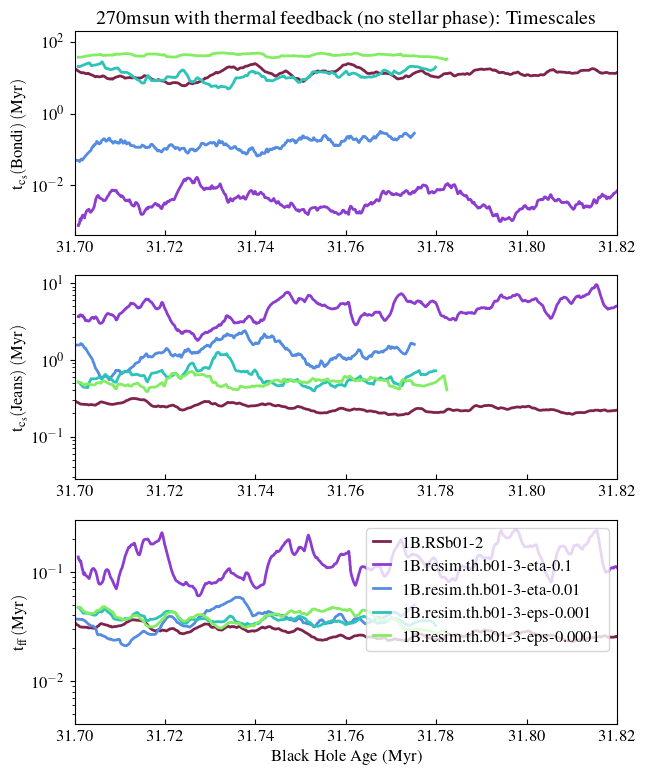

In [10]:
from scipy.interpolate import interp1d

# timescales plot
fig, axs = plt.subplots(3, 1, sharex=True)
window_size = 100
age_units = None # or "t_cs" or None
for j, data_file in enumerate(data_files):

    # Load the CSV file into a DataFrame
    df = pd.read_csv(data_file)

    # sound crossing timescale Bondi
    t_cs = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='bondi'), window_size)

    # # sound crossing timescale Jeans
    t_jeans = adaptive_moving_average(sound_crossing_timescale(df, window_size, type='jeans'), window_size)

    # # find the dynamical timescale 
    mh = 1.6735e-24 # hydrogen mass in g
    density = adaptive_moving_average(df['average density'].values, window_size)
    t_ff = dynamical_timescale_ff(density*mh)/3.15576e13

    # Assuming df['age'].values and t_cs are available and sorted
    x_original = np.linspace(0, 1, len(df['age'].values))  # Normalize original x-axis
    x_new = np.linspace(0, 1, len(t_cs))  # New x-axis for interpolation

    # Create interpolation function
    interp_func = interp1d(x_original, df['age'].values/1e6)

    # Interpolate 'age' to match 't_cs' length
    age_interpolated = interp_func(x_new)

    # plot the timescales
    axs[0].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_cs))), t_cs, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(adaptive_moving_average(age_interpolated, int(len(df['age'].values)/len(t_jeans))), t_jeans, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[2].plot(df['age'].values/1e6, t_ff, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

# Force x-axis ticks to appear on all subplots
for i, ax in enumerate(axs):
    ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, direction="in")
    if i != (num_subplots - 1): ax.set_label('')

# Set labels
for i in range(3):
    axs[i].set_yscale('log')

# set axes labels
axs[0].set_ylabel(r"$\rm t_{c_s} (Bondi) \, (Myr)$", fontdict=None)
axs[1].set_ylabel(r"$\rm t_{c_s} (Jeans) \, (Myr)$", fontdict=None)
axs[2].set_ylabel(r"$\rm t_{ff} \, (Myr)$", fontdict=None)
axs[-1].legend(fontsize=fontsize, ncol=1, loc="upper right", handlelength=1) 
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)


# Set axes limits
#axs[0].set_ylim([2e-5, 2])
axs[-1].set_xlim([31.70, 31.82]) # for truncated view
#axs[-1].set_xlim([0, 1.4])
#axs[1].set_ylim([2e-6, 2e-1]) # 
axs[0].set_title('270msun with thermal feedback (no stellar phase): Timescales')
fig.set_size_inches(7, 9)


# Making (1, 3) panel

In [11]:
def extract_parts(fp):
    # Define the regex pattern to capture the desired parts
    # This pattern looks for a string between the second and third underscore
    # and a DD0 followed by digits
    pattern = r'.*?_([^_]+)_(DD0\d+)_.*'

    # Search using the pattern
    match = re.search(pattern, fp)
    
    # If a match is found, return the captured groups; otherwise return None for both
    if match:
        part1, part2 = match.groups()
        return part1, part2
    else:
        return None, None


In [12]:
import matplotlib.image as mpimg

def make_3_panel_plot(image_paths):
    # Extract the simulation and DD number from the first image path
    sim, dd = extract_parts(image_paths[0]) 

    # Create a figure and a set of subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.333))

    # Loop through the image paths and axs to display each image
    for ax, image_path in zip(axs, image_paths):
        img = mpimg.imread(image_path)  # Load the image
        ax.imshow(img)  # Display the image
        ax.axis('off')  # Turn off axis
    # Manually adjust the positions of the first two subplots to make them overlap
    # ax.set_position([left, bottom, width, height]) where the values are fraction of figure width and height
    axs[0].set_position([0.0, 0.1, 0.4, 0.8])  # Example position for the first subplot
    axs[1].set_position([0.265, 0.1, 0.4, 0.8])  # Adjust so the second subplot overlaps the first
    axs[2].set_position([0.265*2, 0.1, 0.4, 0.8])
    axs[1].set_title('Clumps in {sim} at {dd}'.format(sim=sim, dd=dd))  # Add a title to the figure
    plt.savefig(f'clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Save the combined image to a file
    plt.show()  # Display the figure
    #print(f'Combined image saved as clump_projection_{sim}_{dd}_grav_bound_combined.png')  # Print a message to the console


# 1B.b01

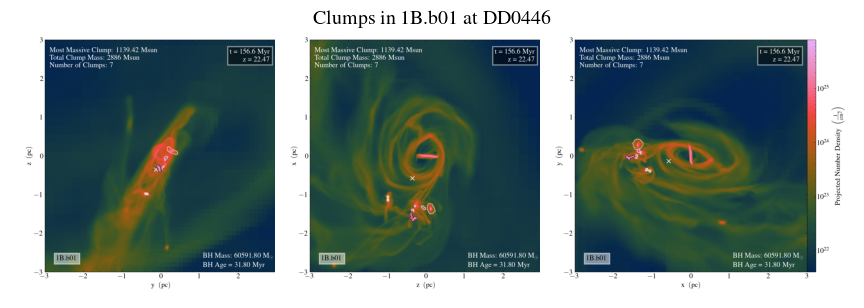

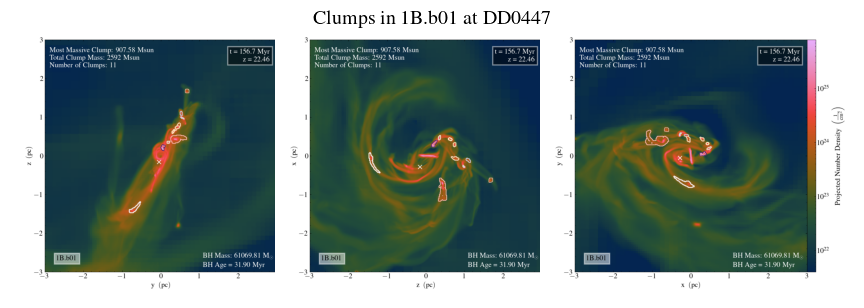

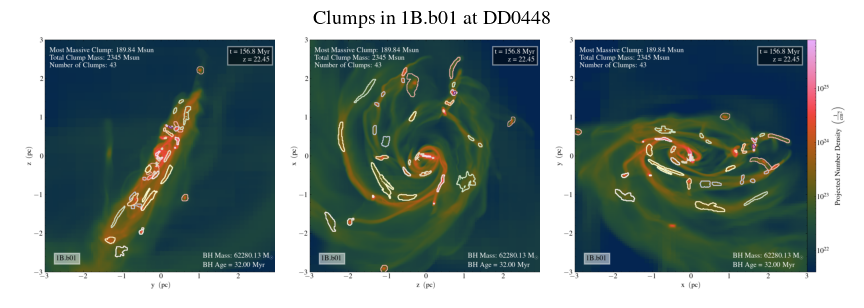

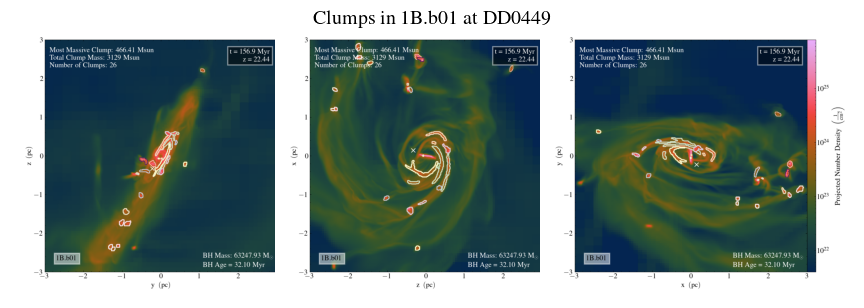

In [13]:
# Paths to your PNG images
image_paths_1 = ['../plots/clump_projection_1B.b01_DD0446_0_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_1_8.70e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0446_2_8.70e+05_grav_bound.png']
image_paths_2 = ['../plots/clump_projection_1B.b01_DD0447_0_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_1_7.51e+05_grav_bound.png', 
               '../plots/clump_projection_1B.b01_DD0447_2_7.51e+05_grav_bound.png']
image_paths_3 = ['../plots/clump_projection_1B.b01_DD0448_0_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_1_1.05e+05.png', 
               '../plots/clump_projection_1B.b01_DD0448_2_1.05e+05.png']
image_paths_4 = ['../plots/clump_projection_1B.b01_DD0449_0_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_1_1.28e+06.png',
                 '../plots/clump_projection_1B.b01_DD0449_2_1.28e+06.png']
make_3_panel_plot(image_paths_1)
make_3_panel_plot(image_paths_2)
make_3_panel_plot(image_paths_3)
make_3_panel_plot(image_paths_4)

# 1B.resim.th.b01-3-eps-0.0001

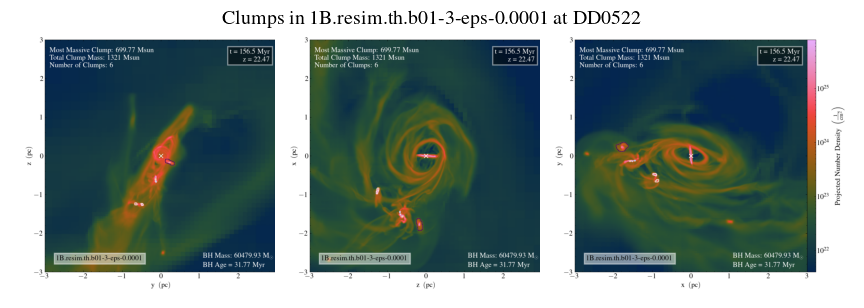

In [14]:
# BH Age = 31.77 Myr
image_paths_1 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.0001_DD0522_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_1)

# 1B.resim.th.b01-3-eps-0.001

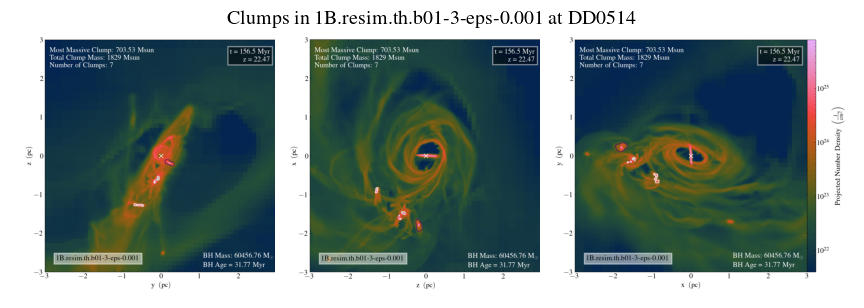

In [15]:
image_paths_2 = ['../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eps-0.001_DD0514_2_1.00e+06_grav_bound.png']
make_3_panel_plot(image_paths_2)

# 1B.resim.th.b01-3-eta-0.01

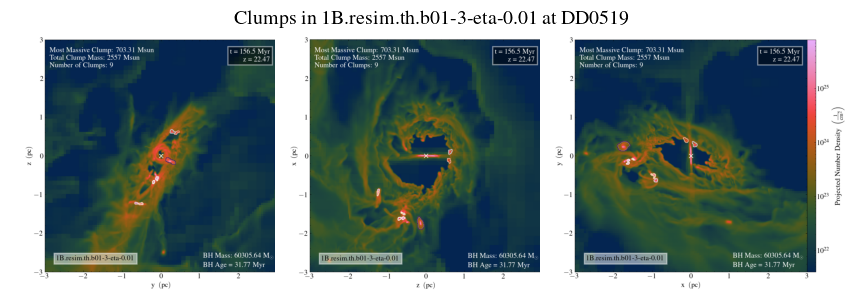

In [16]:
image_paths_3 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_0_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_1_1.00e+06_grav_bound.png',
                    '../plots/clump_projection_1B.resim.th.b01-3-eta-0.01_DD0519_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_3)

# 1B.resim.th.b01-3-eta-0.1

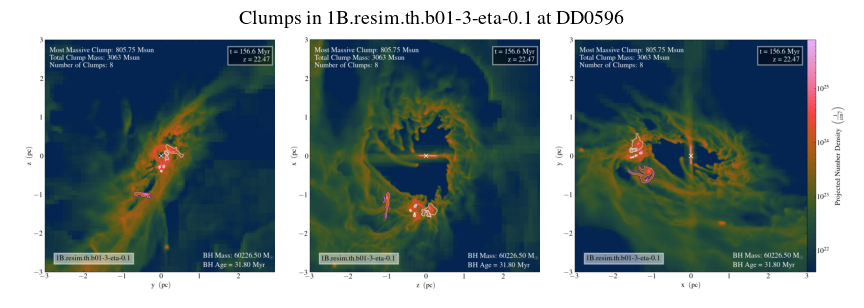

In [17]:
# image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.37e+03_grav_bound.png',
#                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.37e+03_grav_bound.png']
image_paths_4 = ['../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_0_1.00e+06_grav_bound.png',
                 '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_1_1.00e+06_grav_bound.png',
                '../plots/clump_projection_1B.resim.th.b01-3-eta-0.1_DD0596_2_1.00e+06_grav_bound.png']

make_3_panel_plot(image_paths_4)

# Analysing Clumps

In [18]:
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('clump_data.csv', comment='#')  # Replace 'your_data.csv' with your actual file path


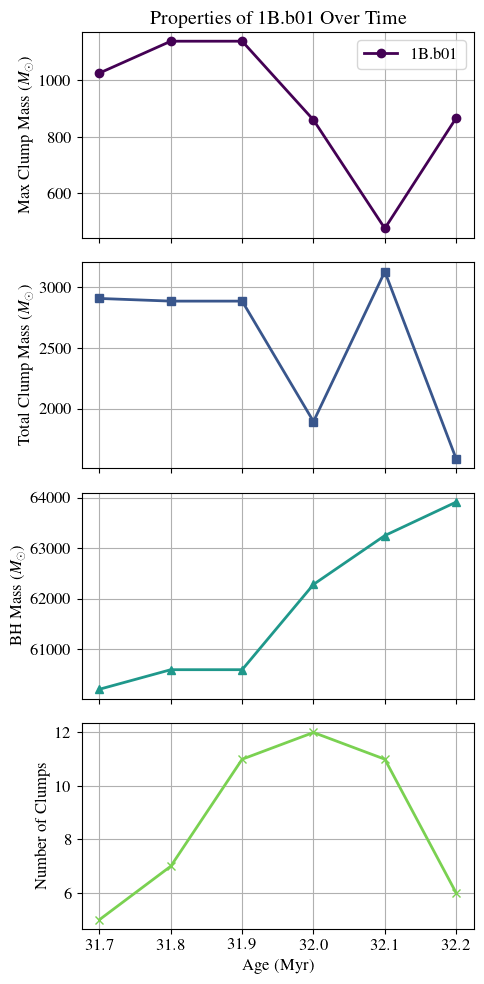

In [19]:
df_1B_b01 = df[df['simulation'] == '1B.b01']

# First, sort the DataFrame by 'age_myr' to ensure the plots are in chronological order
df_1B_b01_sorted = df_1B_b01.sort_values('age_myr')

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(5, 10), sharex=True)  # 4 rows, 1 column, sharing the x-axis

# Generate colors from the viridis colormap
colors = plt.cm.viridis(np.linspace(0, 0.8, 4))  # Generate 4 colors

# Plot max_clump_mass over age_myr
axs[0].plot(df_1B_b01_sorted['age_myr'], df_1B_b01_sorted['max_clump_mass'], marker='o', color=colors[0], label=df_1B_b01['simulation'][0])
axs[0].set_ylabel('Max Clump Mass ($M_\odot$)')
axs[0].set_title('Properties of 1B.b01 Over Time')
axs[0].legend()

# Plot total_clump_mass over age_myr
axs[1].plot(df_1B_b01_sorted['age_myr'], df_1B_b01_sorted['total_clump_mass'], marker='s', color=colors[1])
axs[1].set_ylabel('Total Clump Mass ($M_\odot$)')

# Plot bh_mass over age_myr
axs[2].plot(df_1B_b01_sorted['age_myr'], df_1B_b01_sorted['bh_mass'], marker='^', color=colors[2])
axs[2].set_ylabel('BH Mass ($M_\odot$)')

# Plot no_clumps over age_myr
axs[3].plot(df_1B_b01_sorted['age_myr'], df_1B_b01_sorted['no_clumps'], marker='x', color=colors[3])
axs[3].set_ylabel('Number of Clumps')
axs[3].set_xlabel('Age (Myr)')

# Optional: Add grid to each subplot for better readability
for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()


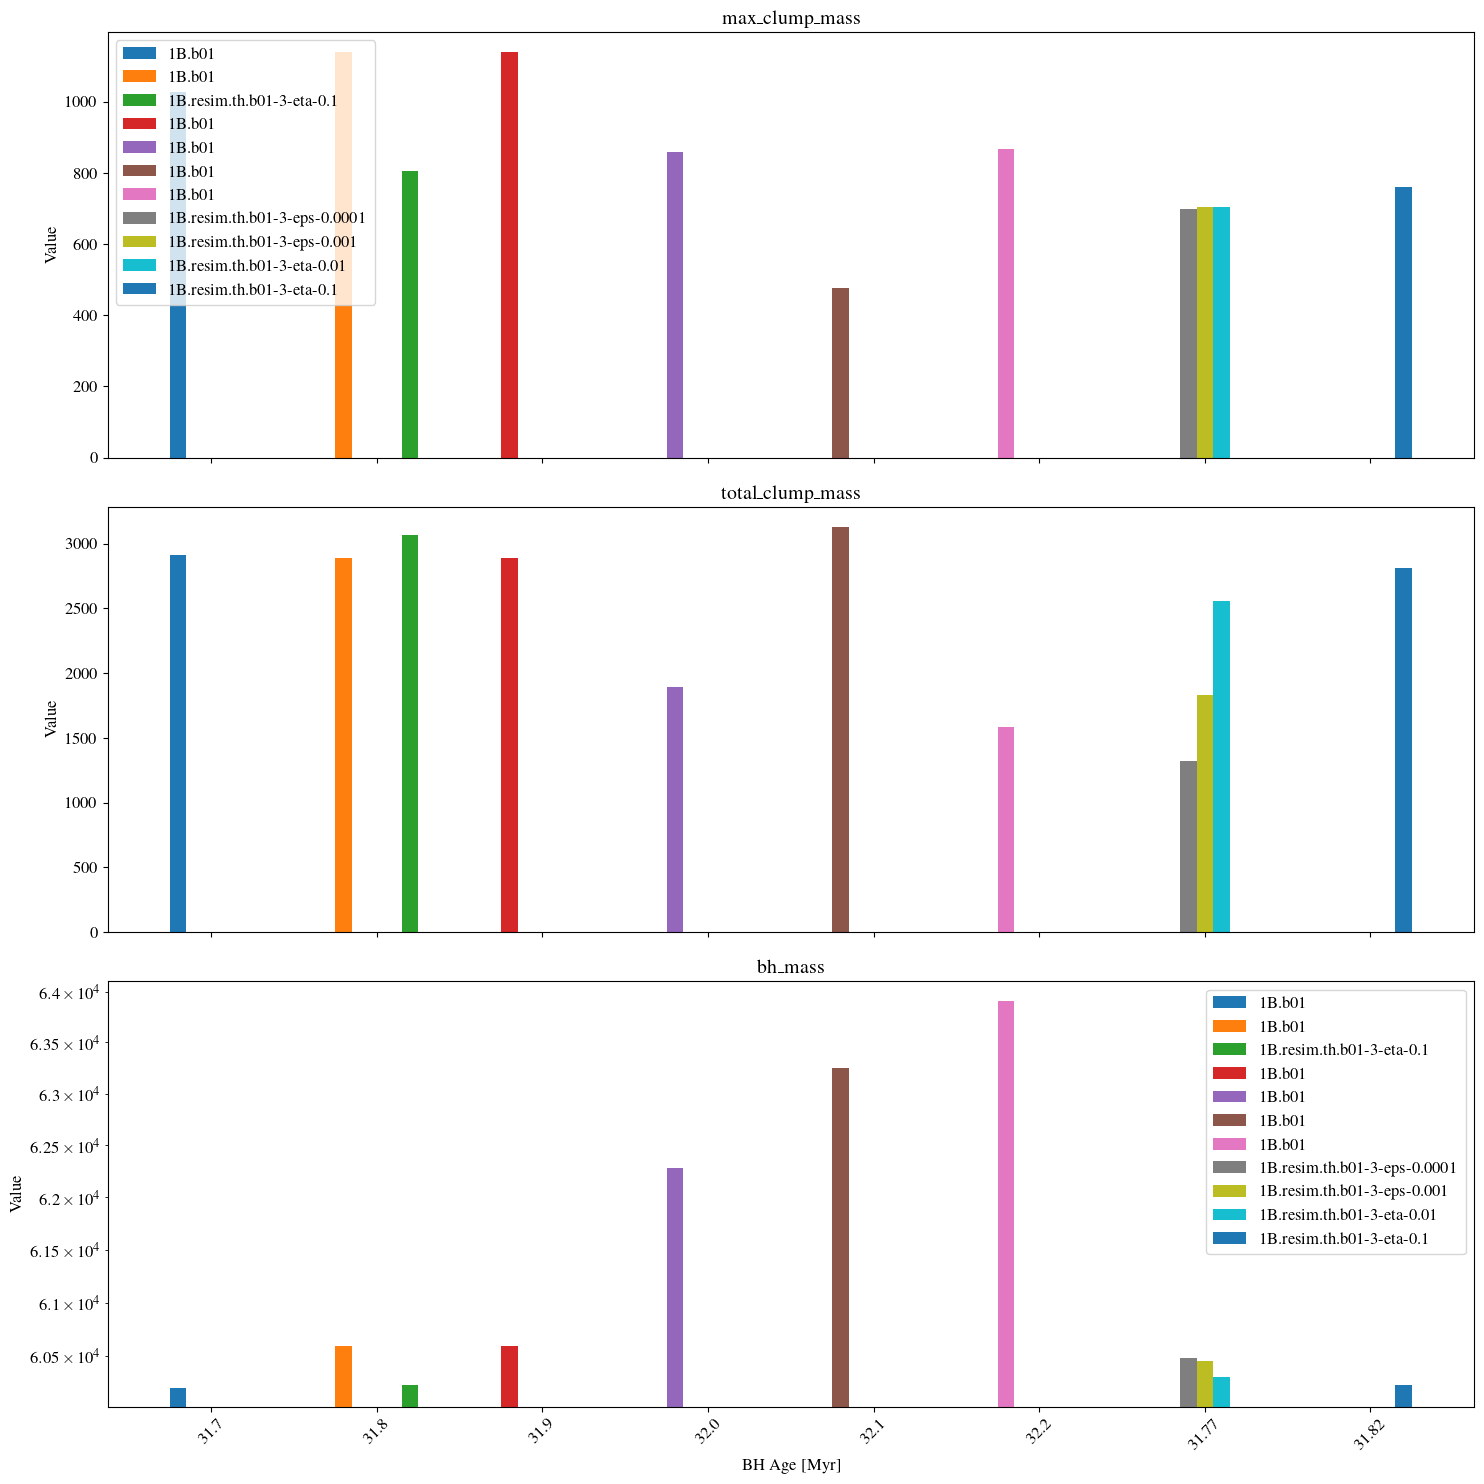

In [39]:
from matplotlib import colormaps
import matplotlib

# Assume df is your DataFrame with the data

# Unique simulations and BH Age values for grouping
simulations = df['simulation'].unique()
ages = df['age_myr'].unique()
properties = ["max_clump_mass", "total_clump_mass", "bh_mass"]  # Replace with your actual properties

# Create a colormap object for 'viridis'
color_map = plt.cm.viridis

# Generate a color for each simulation using the colormap
colors = color_map(np.linspace(0, 1, len(simulations)))
simulation_colors = {simulation: color for simulation, color in zip(simulations, colors)}

# Create subplots - one for each property
fig, axs = plt.subplots(len(properties), 1, figsize=(15, 5 * len(properties)), sharex=True)

# Define the bar width and offset increment
bar_width = 0.1  # Adjust as needed to fit your data
offset_increment = bar_width * (len(simulations) - 1)

# Iterate over properties to create each subplot
for i, property in enumerate(properties):
    # Iterate over the BH Age points for consistent x-coordinates
    for age_idx, age in enumerate(ages):
        # For each age, iterate over simulations to get the respective y-coordinate
        for j, simulation in enumerate(simulations):
            # Filter the data for each simulation at the current age
            data = df[(df['simulation'] == simulation) & (df['age_myr'] == age)]
            # Get the color for the current simulation
            color = simulation_colors[simulation]
            # Check if there is data to plot
            if not data.empty:
                # Calculate offsets
                offsets = np.arange(len(ages)) * (bar_width * len(simulations)) + (bar_width * j)
                # Calculate the bar position for the current simulation
                bar_position = age_idx + j * bar_width
                # Plot the bar if data is available
                axs[i].bar(bar_position, data[property].values[0], width=bar_width, label=simulation)
                
    # Set subplot titles and labels
    axs[i].set_title(property)
    axs[i].set_ylabel('Value')  # Replace with an appropriate label
    axs[i].set_xticks(np.arange(len(ages)) + bar_width * (len(simulations) - 1) / 2)
    axs[i].set_xticklabels(ages)
    axs[i].set_yscale('log') if property == 'bh_mass' else None

# Configure x-axis and add legend to the last subplot
axs[-1].set_xlabel('BH Age (Myr)')
axs[-1].set_xticks(np.arange(len(ages)) + offset_increment / 2)
axs[-1].set_xticklabels(ages, rotation=45)  # Rotate labels if they overlap
axs[-1].legend(loc='upper right')  # Position the legend

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('BH Age [Myr]')
axs[0].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


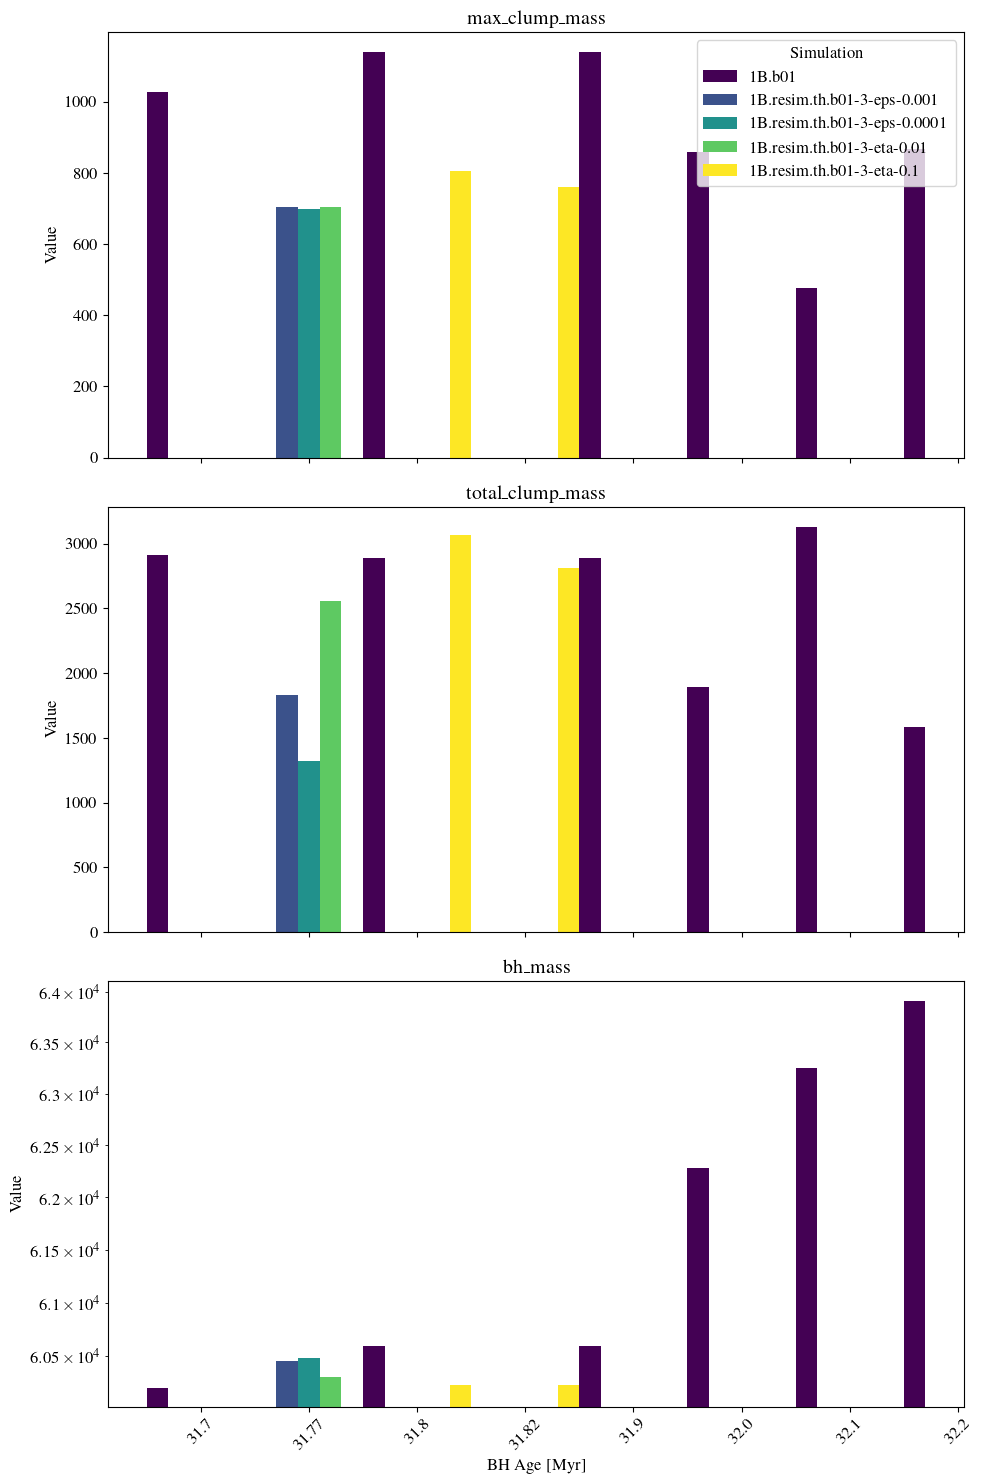

In [58]:

df = df.sort_values('age_myr')

# Unique simulations and BH Age values for grouping
simulations = df['simulation'].unique()
ages = df['age_myr'].unique()
properties = ["max_clump_mass", "total_clump_mass", "bh_mass"]  # Replace with your actual properties

# Create a colormap object for 'viridis'
color_map = plt.cm.viridis

# Generate a color for each simulation using the colormap
colors = color_map(np.linspace(0, 1, len(simulations)))
simulation_colors = {simulation: color for simulation, color in zip(simulations, colors)}

# Create subplots - one for each property
fig, axs = plt.subplots(len(properties), 1, figsize=(10, 5 * len(properties)), sharex=True)

# Define the bar width and offset increment
bar_width = 0.2  # Adjust as needed to fit your data
offset_increment = bar_width * len(simulations)

# Create a dictionary to store whether the legend label has been added for each simulation
# Add legend to the top subplot using the handles we created
# Create a list of handles and labels for the legend, ordered by added_legend keys
handles = []
added_legend = {simulation: False for simulation in simulations}

# Iterate over properties to create each subplot
for i, property in enumerate(properties):
    # Set log scale for 'bh_mass' property
    if property == 'bh_mass':
        axs[i].set_yscale('log')

    # Iterate over the BH Age points for consistent x-coordinates
    for age_idx, age in enumerate(ages):
        # For each age, iterate over simulations to get the respective y-coordinate
        for j, simulation in enumerate(simulations):
            # Filter the data for each simulation at the current age
            data = df[(df['simulation'] == simulation) & (df['age_myr'] == age)]
            # Get the color for the current simulation
            color = simulation_colors[simulation]
            # Check if there is data to plot
            if not data.empty:
                # Calculate the bar position for the current simulation
                bar_position = age_idx + j * bar_width
                # Plot the bar if data is available
                bar = axs[i].bar(bar_position, data[property].values[0], width=bar_width, color=color)
                # Add the simulation to the legend only if it hasn't been added before
                if not added_legend[simulation]:
                    bar.set_label(simulation)
                    added_legend[simulation] = True

    # Set subplot titles and labels
    axs[i].set_title(property)
    axs[i].set_ylabel(r'$M_{BH} (M_{\odot})$') if property == 'bh_mass' else None
    axs[i].set_ylabel(r'Max Clump Mass $(M_{\odot})$') if property == 'max_clump_mass' else None
    axs[i].set_ylabel(r'Total Clump Mass $(M_{\odot})$') if property == 'total_clump_mass' else None

# Configure x-axis for all subplots
labels = list(added_legend.keys())  # This will ensure the order of the keys is preserved
for ax in axs:
    ax.set_xticks(np.arange(len(ages)) + offset_increment / 2 - bar_width / 2)
    ax.set_xticklabels(ages, rotation=45)  # Rotate labels if they overlap
    # Force x-axis ticks to appear on all subplots
    for label in labels:
        for container in ax.containers:
            if container.get_label() == label:
                handles.append(container)


# Create the legend at the top subplot
axs[0].legend(handles, labels, loc='upper right', title='Simulation')

# Set the x-axis label for the last subplot
axs[-1].set_xlabel('BH Age [Myr]')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [54]:
list(added_legend.keys())

['1B.b01',
 '1B.resim.th.b01-3-eps-0.0001',
 '1B.resim.th.b01-3-eps-0.001',
 '1B.resim.th.b01-3-eta-0.01',
 '1B.resim.th.b01-3-eta-0.1']